In [155]:
import pandas as pd
import numpy as np
# import urllib2
# from bs4 import BeautifulSoup
# from imdbpie import Imdb
# from time import sleep
# import time
# import requests
import string
import csv
# import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


In [72]:
pd.set_option("display.max_columns", 100)

In [161]:
shows = pd.read_csv('shows_good_data.csv')

In [99]:
shows.isnull().sum()

first_year                0
fixed_runtime           599
is_action                 0
is_adventure              0
is_animation              0
is_biography              0
is_comedy                 0
is_crime                  0
is_documentary            0
is_drama                  0
is_family                 0
is_fantasy                0
is_game                   0
is_history                0
is_horror                 0
is_music                  0
is_musical                0
is_mystery                0
is_news                   0
is_reality                0
is_romance                0
is_sci                    0
is_short                  0
is_sport                  0
is_talk                   0
is_thriller               0
is_war                    0
is_western                0
release_month           221
release_weekday         221
                       ... 
keyword_parodi            0
keyword_play              0
keyword_polic             0
keyword_power             0
keyword_protagonist 

(array([  1.93100000e+03,   3.30000000e+01,   9.00000000e+00,
          3.00000000e+00,   5.00000000e+00,   1.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          2.00000000e+00]),
 array([   1. ,   72.9,  144.8,  216.7,  288.6,  360.5,  432.4,  504.3,
         576.2,  648.1,  720. ]),
 <a list of 10 Patch objects>)

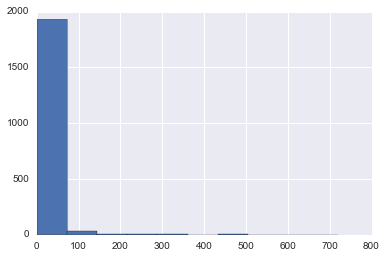

In [163]:
plt.hist(shows['fixed_runtime'].dropna())

In [164]:
fixed_shows = shows[shows['fixed_runtime'] <= 100]

(array([   5.,    0.,    2.,    3.,   23.,   16.,    0.,    6.,  171.,
          46.,   18.,  806.,    0.,    2.,    0.,    5.,   76.,  118.,
          17.,   14.,    4.,   14.,    2.,  576.,    3.,    4.,    0.,
           0.,    0.,    1.,    0.,    0.,    0.,    2.,    1.,    5.,
           0.,    1.,    0.,    1.]),
 array([   1.   ,    3.475,    5.95 ,    8.425,   10.9  ,   13.375,
          15.85 ,   18.325,   20.8  ,   23.275,   25.75 ,   28.225,
          30.7  ,   33.175,   35.65 ,   38.125,   40.6  ,   43.075,
          45.55 ,   48.025,   50.5  ,   52.975,   55.45 ,   57.925,
          60.4  ,   62.875,   65.35 ,   67.825,   70.3  ,   72.775,
          75.25 ,   77.725,   80.2  ,   82.675,   85.15 ,   87.625,
          90.1  ,   92.575,   95.05 ,   97.525,  100.   ]),
 <a list of 40 Patch objects>)

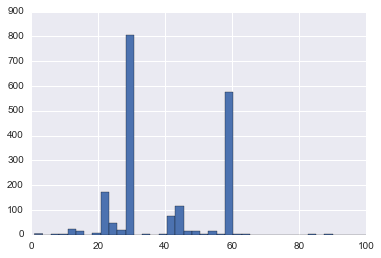

In [170]:
plt.hist(fixed_shows['fixed_runtime'].dropna(), bins=40)

In [118]:
## fixed runtime still has a lot of strange or missing values. 
## adding dummy variables for half-hour- and hour-long shows
shows['half_hour'] = shows['fixed_runtime'].apply(lambda x: 1 if (x>=20) and (x<= 30) else 0)

In [119]:
shows['full_hour'] = shows['fixed_runtime'].apply(lambda x: 1 if (x>=42) and (x<= 60) else 0)

In [120]:
shows['full_hour'].value_counts()

0    1773
1     817
Name: full_hour, dtype: int64

In [121]:
shows['half_hour'].value_counts()

0    1543
1    1047
Name: half_hour, dtype: int64

In [126]:
## dropping original runtime column
shows.drop('fixed_runtime', inplace=True, axis=1)

In [127]:
shows.shape

(2590, 117)

In [97]:
shows.dropna().shape

(1611, 116)

In [57]:
shows.head()

,first_year,fixed_runtime,is_action,is_adventure,is_animation,is_biography,is_comedy,is_crime,is_documentary,is_drama,...,keyword_supernatur,keyword_surreal,keyword_teenag,keyword_versu,keyword_villain,keyword_violenc,keyword_wife,keyword_woman,keyword_york,cancelled
0,2015,NaN,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2015,30.0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2015,21.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2015,22.0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2015,30.0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


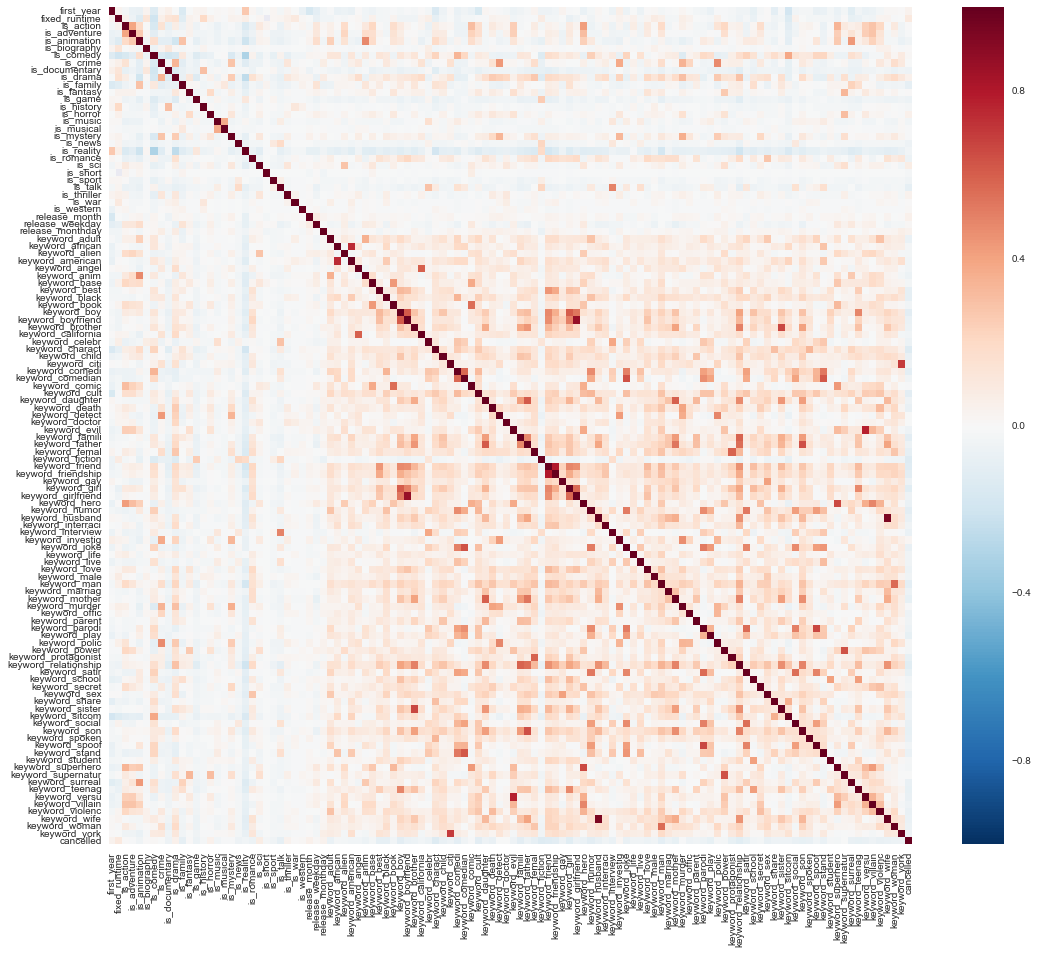

In [171]:
plt.figure(figsize=(18, 15))
sns.heatmap(shows.corr())

In [58]:
shows['stemmed_plot'].head()

0    hip edg anim welcom world magic imagin littl p...
1    follow perki head cheerlead name bella whose l...
2    prehistor earth alien entrust power energem 10...
3    mildmann young bird best friend pair rambuncti...
4    sun hi jodi corki three girl differ person att...
Name: stemmed_plot, dtype: object

In [20]:
# def remove_punctuation(text):
#     exclude = set(string.punctuation)
#     return "".join(ch for ch in text if ch not in exclude)

In [23]:
# shows['stemmed_plot'] = shows['stemmed_plot'].dropna().apply(remove_punctuation)

In [131]:
shows.shape

(2590, 117)

In [132]:
## dropping missing values, down to a little under 2000 shows. 
shows.dropna().shape

(1951, 117)

In [146]:
## defining x and y variables
## removed u'stemmed_plot', u'stemmed_keywords',

y = shows.dropna()['cancelled']
x = shows.dropna()[[u'first_year', 'half_hour', 'full_hour',
                  u'is_action',         u'is_adventure',
               u'is_animation',         u'is_biography',
                  u'is_comedy',             u'is_crime',
             u'is_documentary',             u'is_drama',
                  u'is_family',           u'is_fantasy',
                    u'is_game',           u'is_history',
                  u'is_horror',             u'is_music',
                 u'is_musical',           u'is_mystery',
                    u'is_news',           u'is_reality',
                 u'is_romance',               u'is_sci',
                   u'is_short',             u'is_sport',
                    u'is_talk',          u'is_thriller',
                     u'is_war',           u'is_western',
              u'release_month',      u'release_weekday',
           u'release_monthday',         
                   u'keyword_adult',
            u'keyword_african',        u'keyword_alien',
           u'keyword_american',        u'keyword_angel',
               u'keyword_anim',         u'keyword_base',
               u'keyword_best',        u'keyword_black',
               u'keyword_book',          u'keyword_boy',
          u'keyword_boyfriend',      u'keyword_brother',
         u'keyword_california',       u'keyword_celebr',
            u'keyword_charact',        u'keyword_child',
               u'keyword_citi',       u'keyword_comedi',
           u'keyword_comedian',        u'keyword_comic',
               u'keyword_cult',     u'keyword_daughter',
              u'keyword_death',       u'keyword_detect',
             u'keyword_doctor',         u'keyword_evil',
             u'keyword_famili',       u'keyword_father',
              u'keyword_femal',      u'keyword_fiction',
             u'keyword_friend',   u'keyword_friendship',
                u'keyword_gay',         u'keyword_girl',
         u'keyword_girlfriend',         u'keyword_hero',
              u'keyword_humor',      u'keyword_husband',
          u'keyword_interraci',    u'keyword_interview',
           u'keyword_investig',         u'keyword_joke',
               u'keyword_life',         u'keyword_live',
               u'keyword_love',         u'keyword_male',
                u'keyword_man',      u'keyword_marriag',
             u'keyword_mother',       u'keyword_murder',
             u'keyword_offic',
             u'keyword_parent',       u'keyword_parodi',
               u'keyword_play',        u'keyword_polic',
              u'keyword_power',  u'keyword_protagonist',
       u'keyword_relationship',        u'keyword_satir',
             u'keyword_school',       u'keyword_secret',
                u'keyword_sex',        u'keyword_share',
             u'keyword_sister',       u'keyword_sitcom',
             u'keyword_social',          u'keyword_son',
             u'keyword_spoken',        u'keyword_spoof',
              u'keyword_stand',      u'keyword_student',
          u'keyword_superhero',   u'keyword_supernatur',
            u'keyword_surreal',       u'keyword_teenag',
              u'keyword_versu',      u'keyword_villain',
            u'keyword_violenc',         u'keyword_wife',
              u'keyword_woman',         u'keyword_york']]

In [147]:
## training and test split

x_train, x_test, y_train, y_test = train_test_split(x,y)

## TFIDF

In [10]:
## make lists of all plots before tfidf
## new df joining xtrain and ytrain
## subset of cancelled and renewed plots
## single list of words for cancelled plots, single list of words for renewed plots

In [61]:
training_set_for_plots = pd.concat([x_train, y_train], axis=1)

In [62]:
cancelled = training_set_for_plots[training_set_for_plots['cancelled'] == 1].dropna()
renewed = training_set_for_plots[training_set_for_plots['cancelled'] == 0].dropna()

In [64]:
## turns columns into lists
cancelled_plots = list(cancelled['stemmed_plot'])
renewed_plots = list(renewed['stemmed_plot'])

In [65]:
## turns lists into single strings

new_cancelled_plots = ""
for i in cancelled_plots:
    new_cancelled_plots += (i + " ")
    
new_renewed_plots = ""
for i in renewed_plots:
    new_renewed_plots += (i + " ")

In [66]:
tvec = TfidfVectorizer(stop_words='english')
tvec.fit([new_cancelled_plots, new_renewed_plots])

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [67]:
tfidf_plotwords  = pd.DataFrame(tvec.transform([new_cancelled_plots, new_renewed_plots]).todense(),
                   columns=tvec.get_feature_names(),
                   index=['cancelled', 'renewed'])

In [68]:
tfidf_plotwords.head()

,10,100,1000,10000,100000,1000000,100foot,101,101st,10hour,...,zoey,zombi,zombro,zone,zoo,zookeep,zorak,zord,zordon,zowi
cancelled,0.003238,0.000000,0.000000,0.000000,0.006476,0.000000,0.000000,0.000000,0.004551,0.004551,...,0.000000,0.000000,0.000000,0.004551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
renewed,0.011507,0.010108,0.006065,0.006065,0.001438,0.002022,0.002022,0.002022,0.000000,0.000000,...,0.002022,0.002022,0.002022,0.000000,0.004043,0.002022,0.002022,0.002022,0.002022,0.002022


In [77]:
tfidf_plotwords.transpose().sort_values('cancelled', ascending=False).head(100).transpose()

,new,live,famili,work,seri,life,world,friend,young,brother,time,school,year,tri,father,way,make,team,love,follow,man,person,togeth,group,daughter,detect,adventur,job,becom,home,help,investig,real,deal,thing,stori,forc,star,come,run,michael,mysteri,student,teenag,look,know,citi,start,power,murder,peopl,cop,turn,son,guy,polic,wife,human,drama,high,play,boy,problem,girl,agent,coupl,mother,featur,partner,differ,old,begin,involv,children,return,base,alien,charact,kid,hous,plan,use,discov,success,day,includ,popular,dr,colleg,woman,case,realiti,learn,set,everi,offic,crimin,place,govern,special
cancelled,0.197528,0.184576,0.184576,0.181338,0.158670,0.155432,0.152194,0.139241,0.106860,0.103621,0.100383,0.100383,0.097145,0.097145,0.093907,0.093907,0.093907,0.090669,0.087431,0.087431,0.087431,0.084192,0.084192,0.084192,0.084192,0.084192,0.080954,0.080954,0.077716,0.077716,0.077716,0.074478,0.074478,0.071240,0.071240,0.068002,0.068002,0.068002,0.068002,0.068002,0.068002,0.064763,0.061525,0.061525,0.061525,0.061525,0.061525,0.061525,0.061525,0.061525,0.061525,0.061525,0.061525,0.058287,0.058287,0.058287,0.058287,0.058287,0.058287,0.055049,0.055049,0.055049,0.055049,0.055049,0.051811,0.051811,0.051811,0.051811,0.051811,0.051811,0.051811,0.048573,0.048573,0.048573,0.048573,0.048573,0.048573,0.048573,0.048573,0.045334,0.045334,0.045334,0.045334,0.045334,0.045334,0.045334,0.045334,0.045334,0.045334,0.045334,0.045334,0.045334,0.045334,0.042096,0.042096,0.042096,0.042096,0.042096,0.042096,0.042096
renewed,0.174043,0.244524,0.191304,0.129454,0.166851,0.238770,0.132330,0.205688,0.067604,0.063288,0.094933,0.113632,0.097809,0.135207,0.080549,0.050343,0.089179,0.099248,0.067604,0.117947,0.050343,0.054658,0.080549,0.057535,0.041713,0.044590,0.092056,0.060412,0.061850,0.069042,0.120823,0.038836,0.057535,0.060412,0.037398,0.076234,0.044590,0.064727,0.051781,0.057535,0.017260,0.040274,0.028767,0.056097,0.053220,0.028767,0.102125,0.031644,0.067604,0.024452,0.092056,0.025891,0.046028,0.038836,0.017260,0.043151,0.041713,0.046028,0.037398,0.056097,0.053220,0.044590,0.027329,0.081987,0.056097,0.025891,0.044590,0.038836,0.027329,0.058973,0.044590,0.024452,0.024452,0.064727,0.024452,0.046028,0.027329,0.051781,0.066165,0.048905,0.015822,0.074795,0.038836,0.021576,0.069042,0.070480,0.020137,0.038836,0.030206,0.027329,0.054658,0.041713,0.041713,0.057535,0.050343,0.034521,0.034521,0.031644,0.012945,0.035959


In [76]:
tfidf_plotwords.transpose().sort_values('renewed', ascending=False).head(100).transpose()

,live,life,friend,famili,new,seri,tri,world,work,help,follow,school,citi,best,team,year,time,adventur,peopl,make,girl,togeth,father,stori,use,game,includ,day,contest,anim,home,young,power,love,kid,children,star,brother,like,becom,host,episod,deal,york,answer,job,differ,fight,real,group,set,run,evil,secret,teenag,question,agent,high,person,case,look,town,play,charact,come,relationship,comedi,everi,man,way,win,celebr,variou,music,hous,american,challeng,angel,meet,guest,base,turn,human,alway,end,parent,televis,want,forc,big,old,mother,detect,boy,player,polic,crime,busi,women,learn
cancelled,0.184576,0.155432,0.139241,0.184576,0.197528,0.158670,0.097145,0.152194,0.181338,0.077716,0.087431,0.100383,0.061525,0.042096,0.090669,0.097145,0.100383,0.080954,0.061525,0.093907,0.055049,0.084192,0.093907,0.068002,0.045334,0.042096,0.045334,0.045334,0.022667,0.035620,0.077716,0.106860,0.061525,0.087431,0.048573,0.048573,0.068002,0.103621,0.038858,0.077716,0.025905,0.032382,0.071240,0.035620,0.016191,0.080954,0.051811,0.025905,0.074478,0.084192,0.042096,0.068002,0.022667,0.042096,0.061525,0.016191,0.051811,0.055049,0.084192,0.045334,0.061525,0.038858,0.055049,0.048573,0.068002,0.035620,0.029144,0.042096,0.087431,0.093907,0.038858,0.029144,0.025905,0.032382,0.045334,0.032382,0.012953,0.035620,0.029144,0.019429,0.048573,0.061525,0.058287,0.035620,0.042096,0.042096,0.012953,0.042096,0.068002,0.042096,0.051811,0.051811,0.084192,0.055049,0.000000,0.058287,0.038858,0.029144,0.019429,0.045334
renewed,0.244524,0.238770,0.205688,0.191304,0.174043,0.166851,0.135207,0.132330,0.129454,0.120823,0.117947,0.113632,0.102125,0.102125,0.099248,0.097809,0.094933,0.092056,0.092056,0.089179,0.081987,0.080549,0.080549,0.076234,0.074795,0.071919,0.070480,0.069042,0.069042,0.069042,0.069042,0.067604,0.067604,0.067604,0.066165,0.064727,0.064727,0.063288,0.063288,0.061850,0.061850,0.061850,0.060412,0.060412,0.060412,0.060412,0.058973,0.058973,0.057535,0.057535,0.057535,0.057535,0.057535,0.057535,0.056097,0.056097,0.056097,0.056097,0.054658,0.054658,0.053220,0.053220,0.053220,0.051781,0.051781,0.051781,0.051781,0.050343,0.050343,0.050343,0.050343,0.050343,0.050343,0.048905,0.048905,0.047466,0.047466,0.047466,0.047466,0.047466,0.046028,0.046028,0.046028,0.046028,0.046028,0.046028,0.046028,0.046028,0.044590,0.044590,0.044590,0.044590,0.044590,0.044590,0.044475,0.043151,0.043151,0.043151,0.043151,0.041713


In [71]:
tfidf_plotwords.shape

(2, 7696)

In [79]:
## this was maybe the wrong way to go

important_tfdif_words = ['live', 'life', 'friend', 'tri', 'work', 'help', 'citi', 'best', 
                         'young', 'brother', 'way', 'follow', 'group', 'daughter', 'detect',
                         'investig', 'student', 'know', 'start', 'murder', 'peopl', 'girl', 'game',
                         'includ', 'contest', 'anim', 'young', 'like', 'host', 'york', 'answer', 'women',
                         'cop', 'guy', 'polic', 'coupl', 'mother', 'partner']

In [80]:
## check against count vectorizer. 
## also look into what tfidf is actually doing

### Cross-referencing with count vectorizer

In [81]:
cv = CountVectorizer(stop_words='english', max_features=100, binary=True)

In [83]:
vectorized_cancelled = cv.fit_transform(cancelled_plots).todense()
vectorized_cancelled = pd.DataFrame(vectorized_cancelled, columns=cv.get_feature_names())

In [84]:
vectorized_renewed = cv.fit_transform(renewed_plots).todense()
vectorized_renewed = pd.DataFrame(vectorized_renewed, columns=cv.get_feature_names())

In [85]:
vectorized_renewed.head()

,adventur,american,angel,anim,base,becom,best,big,boy,brother,case,celebr,challeng,charact,children,citi,come,comedi,contest,crime,daughter,day,deal,differ,drama,end,episod,everi,evil,famili,father,featur,fight,follow,forc,friend,game,girl,goe,group,help,high,home,host,human,includ,job,kid,learn,life,like,live,look,love,make,man,meet,mother,music,mysteri,new,old,parent,peopl,person,play,polic,power,real,realiti,relationship,run,school,secret,seri,set,star,stori,talk,team,teenag,televis,time,togeth,town,travel,tri,turn,use,variou,want,way,wife,win,women,work,world,year,york,young
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [89]:
for i in vectorized_renewed.columns:
    print i, vectorized_renewed[i].sum()

 adventur 53
american 29
angel 28
anim 41
base 30
becom 42
best 63
big 26
boy 28
brother 34
case 33
celebr 32
challeng 28
charact 31
children 37
citi 63
come 35
comedi 35
contest 28
crime 27
daughter 26
day 31
deal 40
differ 38
drama 26
end 28
episod 40
everi 33
evil 34
famili 104
father 48
featur 26
fight 38
follow 79
forc 29
friend 123
game 34
girl 48
goe 25
group 37
help 65
high 33
home 43
host 43
human 27
includ 42
job 35
kid 39
learn 28
life 150
like 39
live 138
look 33
love 43
make 60
man 33
meet 32
mother 27
music 28
mysteri 25
new 102
old 28
parent 27
peopl 56
person 34
play 31
polic 26
power 34
real 33
realiti 27
relationship 29
run 34
school 58
secret 29
seri 101
set 40
star 42
stori 50
talk 28
team 40
teenag 35
televis 29
time 52
togeth 49
town 33
travel 26
tri 78
turn 31
use 48
variou 34
want 30
way 34
wife 26
win 26
women 29
work 80
world 87
year 58
york 36
young 46


In [87]:
for i in vectorized_cancelled.columns:
    print i, vectorized_cancelled[i].sum()

adventur 23
anoth 12
base 15
becom 22
begin 15
best 13
boy 14
brother 20
case 13
charact 13
children 12
citi 17
colleg 12
come 19
cop 17
coupl 13
crimin 12
daughter 23
day 14
deal 21
detect 22
differ 15
discov 14
drama 15
everi 12
famili 47
father 25
featur 13
follow 27
forc 20
friend 40
girl 15
group 25
guy 18
help 22
high 15
home 24
hous 14
human 13
includ 13
investig 21
involv 12
job 23
kid 13
know 15
lead 12
learn 13
life 40
like 12
live 50
look 17
love 21
make 26
man 25
marri 12
mother 13
murder 16
mysteri 17
new 55
old 14
origin 13
parent 12
partner 14
peopl 18
person 20
place 13
play 14
polic 16
popular 13
power 17
problem 17
realiti 14
return 13
run 19
school 23
search 12
seri 47
set 13
son 15
star 19
start 17
stori 18
student 18
success 13
team 20
teenag 18
thing 21
time 28
togeth 21
tri 28
turn 19
tv 12
use 12
way 26
wife 15
woman 13
work 51
world 34
year 24
young 31


## top renewed words: 

world (187), life (150), live (138), friend (123), family (104), new (102), series (101),  work (80), 

## top cancelled words:


new (55), work (51), live (50), family (47), series (47), friend (40), life (40), world (34)

* the top words in cancelled plots are the same as the top words in the renewed plots

## Random Forest Model

In [138]:
x_train.shape

(1463, 116)

In [139]:
y_train.shape

(1463,)

In [152]:
## there should be no missing values here, because I already removed the missing values
x_train.dropna().shape

(1463, 114)

In [141]:
y_train.dropna().shape

(1463,)

In [150]:
x_test.shape

(488, 114)

In [151]:
y_test.shape

(488,)

In [148]:
rf = RandomForestClassifier()

rf.fit(x_train, y_train)
rf.score(x_train, y_train)

0.98222829801777167

In [149]:
rf.score(x_test, y_test)

0.68852459016393441

##### Unsurprisingly, the unrestrained random forest model is quite over-fit. Nevertheless, it has a pretty good score on the new data. The base probability for this question is 0.35, and this model scored almost twice as high as that. 

In [154]:
## feature importance

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
feature_importances.head(20)

,importance
first_year,0.107326
release_monthday,0.098708
release_month,0.075282
release_weekday,0.069933
keyword_fiction,0.023026
is_comedy,0.022390
half_hour,0.019961
keyword_charact,0.019956
full_hour,0.018268
is_reality,0.014365


In [156]:
predictions = rf.predict(x_test)
confusion_matrix(y_test, predictions)


array([[290,  58],
       [ 94,  46]])

In [157]:
print classification_report(y_test, predictions)


             precision    recall  f1-score   support

          0       0.76      0.83      0.79       348
          1       0.44      0.33      0.38       140

avg / total       0.67      0.69      0.67       488



#### This model is much better at predicting that a show will be renewed than it is at predicting that a show will be cancelled. There were far more false negatives and false positives than there were true positives. 